In [ ]:
import pandas as pd
import numpy as np
from datetime import date
import re
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import itertools
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_squared_log_error

In [ ]:
sales=pd.read_csv('/content/drive/MyDrive/ColabNotebooks/RNN/sales_2018-01-01_2022-10-10.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#Function to remove outliers
cols = ['col_1', 'col_2'] # one or more
def outlier_remove(df,cols):
  Q1 = df[cols].quantile(0.1)
  Q3 = df[cols].quantile(0.90)
  IQR = Q3 - Q1

  df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
  return df

In [ ]:
def series_replace(ser,arr,regexp):
  new_ser=np.array([])
  for x in ser:
    if x in arr:
      exp=re.findall(regexp,x)
      new_ser=np.append(new_ser,exp[0]) 
    else:
      new_ser=np.append(new_ser,x) 
  return new_ser

In [ ]:
def fill_dates_nr(variants,group):
  x=variants.get_group(group)
  if group in discontinued:
    return x
  if group in discontinuing:
    return x
  day=pd.date_range(x.day.min(), x.day.max(), freq='1D')
  day=[i for i in day if i not in x['day']]
  dates=pd.DataFrame({'day':day})
  dates['net_quantity']=0
  dates['variant_sku']=group
  newdf=pd.concat([dates,x])
  newdf=newdf.sort_values('day')
  newdf['product_price']=newdf['product_price'].fillna(method='ffill')
  newdf['product_price']=newdf['product_price'].fillna(method='bfill')
  #newdf['net_sales'].fillna(x['product_price'].mode()[0],inplace=True)
  return newdf

In [ ]:
#Discount dates
def disc_date(df,var,text,start,end=False):
  if var!='all':
    if not isinstance(var,list):
      var=[var]
  if not end:
    end=date.today()
  dates=pd.date_range(start,end)
  #match dates
  mask1=df['day'].isin(dates)
  #match variants
  if var=='all':
    mask2=[True]*len(df)
  else:
    mask2=[False]*len(df)
    for i in var:
      mask2=mask2 | df['variant_sku'].str.contains(i)
  if text in df.columns:
    df[text+'1']=(mask1*mask2)
    df[text]=df[text]+df[text+'1']
    df.drop(columns=text+'1')
  else:
    df[text]=(mask1 * mask2)
  return df

In [ ]:
def data_prep(sales):
  #Sales only for NA
  NA_sales=sales.loc[sales['shipping_country'].isin(['United States'])]
  NA_sales.drop(columns='shipping_country',inplace=True)
  #scooters only
  NA_scooter=NA_sales[NA_sales['product_type'].isin(['scooter','Light Scooter','electric scooter'])]
  #Only some vendors (EMOVE, Kaabo, Dualtron, Fiido)
  scooter_sales=NA_scooter.loc[NA_scooter['product_vendor'].isin(['EMOVE', 'Kaabo', 'Dualtron', 'FIIDO'])]
  #Change day to datetime
  scooter_sales['day']=pd.to_datetime(scooter_sales['day'])
  #Don't use 2018 data
  scooter_sales=scooter_sales.loc[scooter_sales['day'].dt.year>2018]
  #Set day as index
  scooter_sales.set_index('day',inplace=True)
  return scooter_sales.dropna()

In [ ]:
def title_clean(scooter_sales):
  #capitalize all product title
  scooter_sales['product_title']=scooter_sales['product_title'].str.upper()
  #Remove String inconsistencies in product_title
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=EMOVE CRUISER).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=EMOVE TOURING).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=EMOVE 2.0).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=WOLF KING GT).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('(?<=WOLF WARRIOR GT).*$','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('KAABO\s','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace('\.','')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace("\s\|.*",'')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace("(X2)\sUP",'X2')
  scooter_sales['product_title']=scooter_sales['product_title'].str.replace(r"FIIDO(.*)SEATED",'FIIDO SEATED')
  #remove refurbished
  stock_sales=scooter_sales.loc[~scooter_sales['product_title'].str.match('REFURBISHED')]
  return stock_sales

In [ ]:
def variant_clean(stock_sales):
  #Fix Variant
  #Remove unknown digits
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('-\d+-','-')
  #Remove Early string and dashes
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('[eE]arly\-+','')
  #Remove -new string
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('-[nN]ew','')
  #add color to mantis king with no color
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('^Kaabo-Mantis-King-GT$','Kaabo-Mantis-King-GT-Black')
  #replace discontinued FIIDO
  stock_sales['variant_sku']=series_replace(stock_sales['variant_sku'],['FIIDO-Q1s-Red','FIIDO-Q1s-White','FIIDO-Q1-Green','FIIDO-Q1-Red','FIIDO-Q1-White'],'\w+\-\w+')
  #Remove 2022
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('2022\-','')
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.replace('[kK]ing-[sS]treet','king')
  #remove touring green
  stock_sales=stock_sales.loc[stock_sales['variant_sku']!='touring-green']
  #Capitalize 
  stock_sales['variant_sku']=stock_sales['variant_sku'].str.upper()
  #Remove random emove
  stock_sales=stock_sales.loc[~(stock_sales['variant_sku'].isin(['EMOVE-BLACK','EMOVE-GREEN','EMOVE-ORANGE','EMOVE-WHITE','FIIDO-Q1','FIIDO-Q1S']))]
  stock_sales.dropna(inplace=True)
  return stock_sales

In [ ]:
def data_clean(stock_sales):
  #remove negative orders
  stock_sales=stock_sales[stock_sales['net_quantity']>=1]
  #Drop columns that won't be used
  new_df=stock_sales.drop(columns=['product_title','product_type']).reset_index()
  #discounts divide by order
  new_df['discounts']=new_df['discounts']/new_df['net_quantity']
  #Remove discounts that are too high
  new_df['disc_per']=np.abs(new_df['discounts']/new_df['product_price'])
  new_df=new_df[new_df['disc_per']<=0.08]
  new_df.drop(columns='disc_per',inplace=True)
  return new_df[['day','product_vendor','variant_sku','product_price','net_quantity']]

In [ ]:
scooter_sales=data_prep(sales)
stock_sales=title_clean(scooter_sales)
stock_sales=variant_clean(stock_sales)
new_df=data_clean(stock_sales)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will chan

In [ ]:
discontinued=['wolf-warrior-x-black-street','wolf-warrior-base-black-street','wolf-warrior-x-gold-street','Wolf-Warrior-Street-Tires','Wolf-Warrior-Off-Road-Tires','dualtron-thunder-tronic']
discontinued=[i.upper() for i in discontinued]

In [ ]:
discontinuing=['dualtron-x2','dualtron-thunder','dualtron-mini','dualtron-storm']
discontinuing=[i.upper() for i in discontinuing]

In [ ]:
#Separate dataframe to different variants
variants=new_df.groupby('variant_sku')

In [ ]:
df=pd.DataFrame()
for i in variants.groups.keys():
  df=pd.concat([df,fill_dates_nr(variants,i)])

In [ ]:
df=df.groupby([col for col in df.columns if col!='net_quantity']).sum().reset_index()
df.sort_values(by=['variant_sku','day'],axis=0,inplace=True)

In [ ]:
discontinued=['wolf-warrior-x-black-street','wolf-warrior-base-black-street','wolf-warrior-x-gold-street','Wolf-Warrior-Street-Tires','Wolf-Warrior-Off-Road-Tires','dualtron-thunder-tronic']
discontinued=[i.upper() for i in discontinued]

In [ ]:
#Separate dataframe to different variants
variants=new_df.groupby('variant_sku')

print(variants)

In [ ]:
df=pd.DataFrame()
for i in variants.groups.keys():
  df=pd.concat([df,fill_dates_nr(variants,i)])

print(df)

            day  net_quantity                    variant_sku product_vendor  \
0    2021-08-27             0  BLACK-KAABO-OFFROAD-WOLF-KING            NaN   
6837 2021-08-27             1  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo   
1    2021-08-28             0  BLACK-KAABO-OFFROAD-WOLF-KING            NaN   
2    2021-08-29             0  BLACK-KAABO-OFFROAD-WOLF-KING            NaN   
7120 2021-08-30             3  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo   
...         ...           ...                            ...            ...   
7847 2022-06-28             2    WOLF-WARRIOR-X-BLACK-STREET          Kaabo   
7848 2022-06-13             1    WOLF-WARRIOR-X-BLACK-STREET          Kaabo   
7841 2022-08-19             1     WOLF-WARRIOR-X-GOLD-STREET          Kaabo   
7842 2022-08-28             1     WOLF-WARRIOR-X-GOLD-STREET          Kaabo   
7844 2022-06-28             1     WOLF-WARRIOR-X-GOLD-STREET          Kaabo   

      product_price  
0            2999.0  
6837   

In [ ]:
df=df.groupby([col for col in df.columns if col!='net_quantity']).sum().reset_index()
df.sort_values(by=['variant_sku','day'],axis=0,inplace=True)

print(df)

            day                    variant_sku product_vendor  product_price  \
3139 2021-08-27  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3169 2021-08-30  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3180 2021-08-31  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3255 2021-09-09  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3283 2021-09-11  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
...         ...                            ...            ...            ...   
5857 2022-06-28    WOLF-WARRIOR-X-BLACK-STREET          Kaabo         2395.0   
5905 2022-07-03    WOLF-WARRIOR-X-BLACK-STREET          Kaabo         2395.0   
5858 2022-06-28     WOLF-WARRIOR-X-GOLD-STREET          Kaabo         2295.0   
6356 2022-08-19     WOLF-WARRIOR-X-GOLD-STREET          Kaabo         2295.0   
6432 2022-08-28     WOLF-WARRIOR-X-GOLD-STREET          Kaabo         2295.0   

      net_quantity  
3139             1

In [ ]:
discontinued=['wolf-warrior-x-black-street','wolf-warrior-base-black-street','wolf-warrior-x-gold-street','Wolf-Warrior-Street-Tires','Wolf-Warrior-Off-Road-Tires','dualtron-thunder-tronic']
discontinued=[i.upper() for i in discontinued]

In [ ]:
discontinuing=['dualtron-x2','dualtron-thunder','dualtron-mini','dualtron-storm']
discontinuing=[i.upper() for i in discontinuing]

In [ ]:
df=df[~df['variant_sku'].isin(discontinued)]
df=df[~df['variant_sku'].isin(discontinuing)]

In [ ]:
print(df)

            day                    variant_sku product_vendor  product_price  \
3139 2021-08-27  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3169 2021-08-30  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3180 2021-08-31  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3255 2021-09-09  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
3283 2021-09-11  BLACK-KAABO-OFFROAD-WOLF-KING          Kaabo         2999.0   
...         ...                            ...            ...            ...   
6700 2022-10-01               WKGT-GOLD-STREET          Kaabo         3595.0   
6704 2022-10-02               WKGT-GOLD-STREET          Kaabo         3595.0   
6725 2022-10-05               WKGT-GOLD-STREET          Kaabo         3595.0   
6739 2022-10-07               WKGT-GOLD-STREET          Kaabo         3595.0   
6754 2022-10-10               WKGT-GOLD-STREET          Kaabo         3595.0   

      net_quantity  
3139             1

In [ ]:
def split_data(dataset, sc):
  train_sc_df = dataset[:-50] #150
  test_sc_df = dataset[len(train_sc_df)-50:] #50

  # standardization
  
  train_sc = np.array(train_sc_df).reshape((-1,1))
  train_sc = sc.fit_transform(train_sc)
  train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train_sc_df.index)
  print("------------train_sc_df--------------")
  print(train_sc_df.head())
  train_index_df = train_sc_df

  test_sc = np.array(test_sc_df).reshape((-1,1))
  test_sc = sc.transform(test_sc)
  test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test_sc_df.index)
  print("------------test_sc_df--------------")
  print(test_sc_df.head())

  test_index_df = test_sc_df

  """
  Shift는 이전 정보를 row에서 다시 쓰기 위한 pandas의 함수
  이를통해 과거의 값들을 shift_s와 같은 형태로 저장할 수 있다.
  과거 값은 총 12개를 저장하면, timestep은 12개가 된다.
  우리의 목적은 과거값 shift 1~8 (일주일의 자료)를 통해 형재값 scaled를 예측하는 것이다.
  """
  for s in range(1, 8):
    train_sc_df['shift_{}'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['shift_{}'.format(s)] = test_sc_df['Scaled'].shift(s)

  print("------------shifted train_sc_df--------------")
  print(train_sc_df.head(8))

  print("------------shifted test_sc_df--------------")
  print(test_sc_df.head(8))

  """
  NaN값은 제거하고, shift_1 ~ shift_7은 X로 Scaled는 Y로 지정
  """
  X_train = train_sc_df.dropna().drop('Scaled', axis=1)
  y_train = train_sc_df.dropna()[['Scaled']]

  X_test = test_sc_df.dropna().drop('Scaled', axis=1)
  y_test = test_sc_df.dropna()[['Scaled']]

  y_train_index = y_train
  y_test_index = y_test

  X_train = X_train.values
  X_test= X_test.values

  y_train = y_train.values
  y_test = y_test.values

  return X_train, X_test, y_train, y_test, y_train_index, y_test_index

In [ ]:
from sklearn.preprocessing import StandardScaler

sample_df = df[df['variant_sku']=='CRUISER-BLACK']

sample = sample_df['net_quantity']
sample.index = sample_df['day']

scaler = StandardScaler()
# scaler.
X_train, X_test, y_train, y_test, y_train_index, y_test_index = split_data(sample, scaler)

------------train_sc_df--------------
              Scaled
day                 
2019-07-30 -1.051653
2019-08-03 -1.051653
2019-08-04 -1.051653
2019-08-06 -1.051653
2019-08-07 -1.051653
------------test_sc_df--------------
              Scaled
day                 
2022-05-30  0.325267
2022-05-31 -0.133706
2022-06-01 -0.133706
2022-06-02 -0.133706
2022-06-03  1.243213
------------shifted train_sc_df--------------
              Scaled   shift_1   shift_2   shift_3   shift_4   shift_5  \
day                                                                      
2019-07-30 -1.051653       NaN       NaN       NaN       NaN       NaN   
2019-08-03 -1.051653 -1.051653       NaN       NaN       NaN       NaN   
2019-08-04 -1.051653 -1.051653 -1.051653       NaN       NaN       NaN   
2019-08-06 -1.051653 -1.051653 -1.051653 -1.051653       NaN       NaN   
2019-08-07 -1.051653 -1.051653 -1.051653 -1.051653 -1.051653       NaN   
2019-08-12 -1.051653 -1.051653 -1.051653 -1.051653 -1.051653 -1.051

In [47]:
X_train_t = X_train.reshape(X_train.shape[0], 7, 1)
X_test_t = X_test.reshape(X_test.shape[0], 7, 1)

# print(X_test_t)
print("최종 DATA")
print(X_train_t.shape)

# [[[1], [2], [3], [4], [5], [6], [7]]]

최종 DATA
(707, 7, 1)


In [ ]:
# //Tensorflow//
import keras.backend as K

K.clear_session()
model = Sequential()

# units = 50 --> 25 50 100 150 실험적으로 찾아야되는 부분
model.add(LSTM(units = 100, return_sequences = True, input_shape = (7, 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100, return_sequences = True))
model.add(Dropout(0.2))

# 마지막은 return_seqences = False
model.add(LSTM(units = 100))
model.add(Dropout(0.2))

model.add(Dense(units = 1))

print(model.summary())
# model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 7, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 7, 100)            80400     
                                                                 
 dropout_1 (Dropout)         (None, 7, 100)            0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [ ]:
"""

각 스쿠터 class 별로 전부 학습 --> 스쿠터가 N개  스쿠터이름_Model N개.

특정 스쿠터가 들어왔을때 그 스쿠터에 대한 학습이루어진 Model weight를 load해와서 test를 진행.

"""

In [ ]:
from tensorflow.python.eager.context import monitoring

model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())

# early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)
# batch_size = 1 : 7
# batch_size = 20 : 7 * 20 --> 140 
# 1 2 4 8 16 32 64 128 256 512
model.fit(X_train_t, y_train, epochs=300, batch_size=32, verbose=1)

Epoch 1/300
23/23 [==============================] - 7s 27ms/step - loss: 0.7907
Epoch 2/300
23/23 [==============================] - 1s 26ms/step - loss: 0.7629
Epoch 3/300
23/23 [==============================] - 1s 26ms/step - loss: 0.7333
Epoch 4/300
23/23 [==============================] - 1s 25ms/step - loss: 0.7251
Epoch 5/300
23/23 [==============================] - 1s 25ms/step - loss: 0.7331
Epoch 6/300
23/23 [==============================] - 1s 25ms/step - loss: 0.7223
Epoch 7/300
23/23 [==============================] - 1s 25ms/step - loss: 0.7292
Epoch 8/300
23/23 [==============================] - 1s 26ms/step - loss: 0.7399
Epoch 9/300
23/23 [==============================] - 1s 26ms/step - loss: 0.7206
Epoch 10/300
23/23 [==============================] - 1s 26ms/step - loss: 0.7228
Epoch 11/300
23/23 [==============================] - 1s 26ms/step - loss: 0.7332
Epoch 12/300
23/23 [==============================] - 1s 26ms/step - loss: 0.7575
Epoch 13/300
23/23 [=====

In [ ]:
# y_pred = model.predict(X_test_t)

In [ ]:
# print(y_pred[:5])
# print(y_test[:5])

3/3 [==============================] - 0s 14ms/step
MSE SCORE : 2.5907626625681033
RMSE SCORE : 1.6095846242332532
R2 SCORE : 0.1183700712719733
            Scaled
day               
2022-06-06     3.0
2022-06-07     1.0
2022-06-07     2.0
2022-06-08     2.0
2022-06-10     2.0
...            ...
2022-09-27     5.0
2022-09-29     4.0
2022-09-30     2.0
2022-10-03     2.0
2022-10-05     2.0

[93 rows x 1 columns]


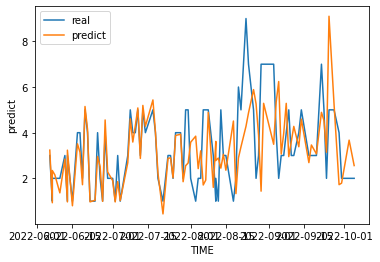

In [44]:
# print(y_pred_inver[:5])
y_pred = model.predict(X_test_t)

y_test_inver = scaler.inverse_transform(y_test)
y_pred_inver = scaler.inverse_transform(y_pred)

MSE = mean_squared_error(y_test_inver, y_pred_inver) 
RMSE = np.sqrt(MSE)
R2 = r2_score(y_test_inver, y_pred_inver)

print(f'MSE SCORE : {MSE}')
print(f'RMSE SCORE : {RMSE}')
print(f'R2 SCORE : {R2}')

y_test_inver_df = pd.DataFrame(y_test_inver, columns=['Scaled'], index=y_test_index.index)
print(y_test_inver_df)
y_pred_inver_df = pd.DataFrame(y_pred_inver, columns=['Scaled'], index=y_test_index.index)

# plt.figure(figsize=(150,150))
plt.plot(y_test_inver_df, label='real')
plt.plot(y_pred_inver_df, label='predict')
plt.xlabel('TIME')
plt.ylabel('predict')
plt.legend()
plt.show()

# 50일 평균 1.6개  2개
# 7주일 : 7일 예측을 전부 따로 한것 --> 합 : 7일 평균
# -2개 == 2개를 많이
# -2개 +2개 // 2개

23/23 [==============================] - 0s 9ms/step
MSE SCORE : 0.1684506473566975
RMSE SCORE : 0.41042739596266903
R2 SCORE : 0.964473670553782


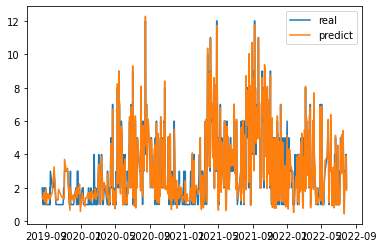

In [ ]:
y_pred_train_data = model.predict(X_train_t)

y_origin_train_data_inver = scaler.inverse_transform(y_train)
y_pred_train_data_inver = scaler.inverse_transform(y_pred_train_data)
# print(y_pred_inver[:5])

MSE = mean_squared_error(y_origin_train_data_inver, y_pred_train_data_inver) 
RMSE = np.sqrt(MSE)
R2 = r2_score(y_origin_train_data_inver, y_pred_train_data_inver)

print(f'MSE SCORE : {MSE}')
print(f'RMSE SCORE : {RMSE}')
print(f'R2 SCORE : {R2}')

y_origin_train_data_inver = pd.DataFrame(y_origin_train_data_inver, columns=['Scaled'], index=y_train_index.index)
y_pred_train_data_inver = pd.DataFrame(y_pred_train_data_inver, columns=['Scaled'], index=y_train_index.index)

plt.plot(y_origin_train_data_inver, label='real')
plt.plot(y_pred_train_data_inver, label='predict')
plt.legend()
plt.show()